In [1]:
import os
import sys
import glob
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
root_dir = Path(r"C:\\Users\\isogai lab\\Desktop\\hamfish")
os.chdir(root_dir)
os.getcwd()

'C:\\Users\\isogai lab\\Desktop\\hamfish'

In [3]:
# change this line to the location of seqfish pipeline scripts
pipeline_path = root_dir / "src" / "preprocessing"
sys.path.append(str(pipeline_path))

from a_stitch_img import *
from b_calculate_hyb_shifts import *
from c_calculate_cell_position import *
from d_calculate_complex_brightness import *
from e_rotate_dapi_cellpos import *

#### Set the data path

In [4]:
hamfish_Dir = root_dir / "example"
expname = 'test'

In [5]:
### get path ###
experimentPath = hamfish_Dir / 'processed' / expname # the main output folder
downstreamPath = hamfish_Dir / 'downstream' / expname
tiledviewPath = hamfish_Dir / 'tiledviews' / expname

correctDapiPath = tiledviewPath / 'corrected_lumi' # the output directory of lumi correction
exactbigdapiPath = tiledviewPath / 'exact_big_dapi'
cellposPath = downstreamPath / 'cell_position'

coordinate_file = tiledviewPath / (expname + '_coordinates.csv')
coorSavePath = downstreamPath / 'exact_coor' 

In [6]:
# this defines which bit belong to which hyb and the color channel for each bit
# useful for chromatic abberation correction
hyb_bit_dict = {'hyb1': [4, 7, 56], 'hyb2': [1, 9, 17], 'hyb3': [2, 25, 27], 'hyb4': [3, 15, 32], 'hyb5': [5, 16, 12], 'hyb6': [6, 21, 29], 'hyb7': [14, 18, 19], 'hyb8': [22, 26, 20], 'hyb9': [30, 28, 11], 'hyb10': [33, 24, 10], 'hyb11': [58, 13, 54]}

# This defines the gene for each bit in hamfish
gene_bit_dict = {4: 'Slc17a6', 7: 'Penk', 56: 'Grik1', 1:'Reln', 9:'Cnr1', 17: 'Ecel1',
2: 'Ndnf', 25: 'Kit', 27: 'Lhx6', 3: 'Slc32a1', 15: 'Adcyap1', 32: 'Cbln4',
5: 'Cck', 16: 'Cartpt', 12: 'Prlr', 6: 'Nts', 21: 'Calcr', 29: 'Oprk1',
14: 'Tac1',  18: 'Calb2', 19: 'Htr2c', 22: 'Dlk1',  26: 'Nos1',  20: 'Pdyn',
30: 'Calb1', 28: 'Esr2', 11: 'Lamp5',  33:'Sst',  24: 'Esr1', 10: 'Trh',
58: 'Npy',  13: 'Fos', 54: 'Gal'}

# the zscan range for each view
view_list = [(16, 27), (30, 41)]

bitlist = [b for b in list(gene_bit_dict.keys()) if b != 0]

genelist = list(gene_bit_dict.values())

num_digit = 3 # how the zscan folder name is structured

#### 1. Illumination correction

In [ ]:
### refer to the matlab runscript

#### 2. get coordinates 

In [7]:
# generate the coordinate files for each dapi among a view
# output two files for each view: 1) how the zscan are tiled 2) the exact pixel coordinate for each zscan 
get_new_coord_experiment(coordinate_file, view_list, downstreamPath, correctDapiPath, coorSavePath, num_digit)

In [ ]:
# for single view
# get_new_coord(coordinate_file, (16, 27), downstreamPath, correctDapiPath, coorSavePath, num_digit)

In [8]:
# stitch the corrrected hapi images into a view
stitch_dapi_experiment(view_list, downstreamPath, exactbigdapiPath, correctDapiPath, coorSavePath, num_digit)

In [ ]:
# for single view
# stitch_dapi((16, 27), downstreamPath, exactbigdapiPath, correctDapiPath, coorSavePath, num_digit)

#### 3. cellpose

In [ ]:
!python -m cellpose --pretrained_model cyto --diameter 75 --dir 'C:/Users/isogai lab/Desktop/hamfish/example/tiledviews/test' --chan 0 --save_tif --no_npy --use_gpu --verbose --mask_threshold -2

#### 4. calculate shifts this can be run parallel to step 1 2 3 4


In [9]:
run_calculate_shifts_experiment(experimentPath, downstreamPath, view_list, hyb_bit_dict)

All done!


In [18]:
# for single view
# run_calculate_shifts_view(experimentPath, downstreamPath, (16, 27), list(hyb_bit_dict.keys()))

Calculating shifts for  (16, 27)


#### 5. calculate cell X Y position, you can tune the high and low threshold value to get rid small / big cells

In [10]:
# parameters are sd to the mean cellsize, eg. low = 1.5 means filter all cells that size below mean - 1.5 sd
filt = True
overwrite = True
low = 1.5
high = 3
run_calculate_cellpos_experiment(exactbigdapiPath, downstreamPath, view_list, filt, low, high, overwrite)

Processing:  C:\Users\isogai lab\Desktop\hamfish\example\tiledviews\test\exact_big_dapi


In [ ]:
# 5.1 optional, plot cell id on top of cellpose result, for check bugs
for view in view_list:
    plot_cell_pos(view, downstreamPath, exactbigdapiPath)

#### 6. calculate complex brightness

In [ ]:
fftthr = 200
correct = True  # whether to use shading correction
bit_ratio_filter = {1: 0.035, 13: 0.035, 14: 0.035, 4: 0.035, 7: 0.035, 56: 0.035, 9: 0.035, 17: 0.035, 2: 0.035,
25: 0.035, 27: 0.035, 3: 0.035, 15: 0.035, 32: 0.035, 5: 0.035, 16: 0.035, 12: 0.035, 6: 0.035, 21: 0.1, 29: 0.035,
18: 0.1, 19: 0.035, 22: 0.1, 26: 0.035, 20: 0.035, 30: 0.035, 28: 0.035, 11: 0.035, 33: 0.1, 24: 0.035, 10: 0.035,
58: 0.035, 54: 0.035}   ### get rid of the dust spots in the data, 0.035 is the ratio of area(> 99/9% intensity) / area(> 98% intensity)
# if this ratio is over 0.035, set the lumi to 0 for that bit that cell, turned off for some bits, like Sst

# remember to configure this if needed
correct_files = [pipeline_path / "correct_lumi" / 'average_488.tif',
                 pipeline_path / "correct_lumi" / 'average_cy3.tif',
                 pipeline_path / "correct_lumi" / 'average_cy5.tif']

In [ ]:
run_calculate_cell_lumi_seqfish_experiment(fftthr, 
                                           view_list, 
                                           experimentPath, 
                                           exactbigdapiPath, 
                                           coorSavePath, 
                                           downstreamPath, 
                                           hyb_bit_dict, 
                                           num_digit, 
                                           correct, 
                                           bit_ratio_filter,
                                           correct_files)

#### 7. Rotate the dapi and cell coordinates 

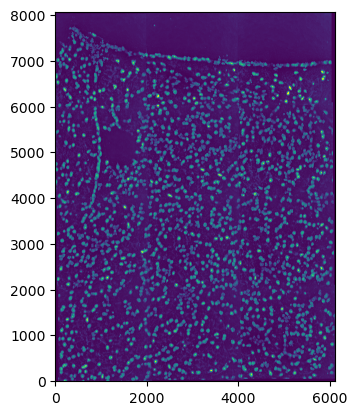

In [ ]:
imagefp = glob.glob(str(exactbigdapiPath) + '/*_clear.tif')[0]
plt.imshow(Image.open(imagefp), origin = 'lower')

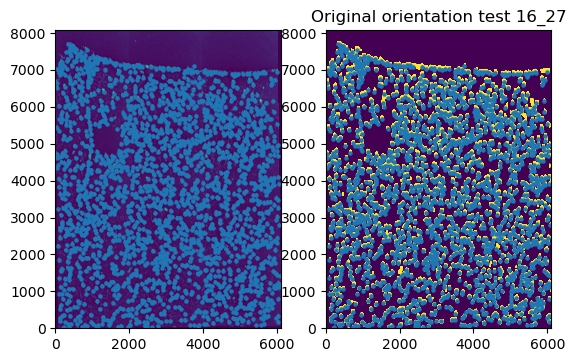

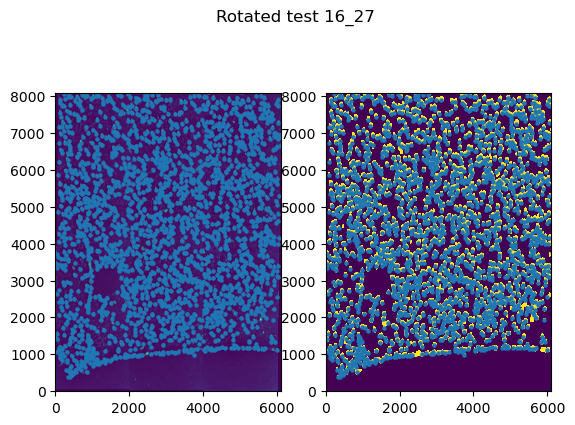

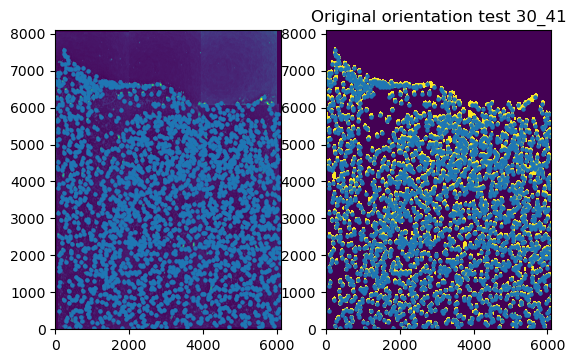

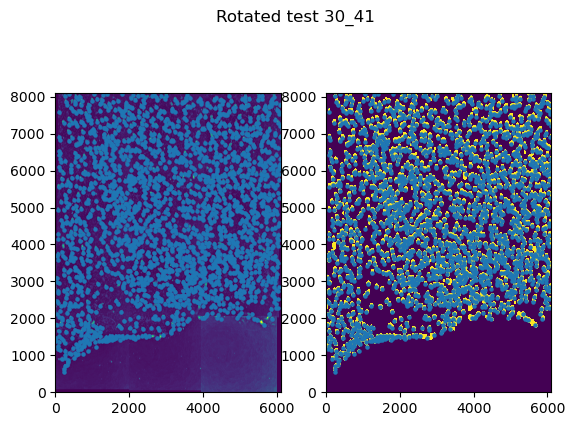

In [7]:
rotation_angle = 180
flip_horizontal = True
rotate_dapi_cellpos(exactbigdapiPath, cellposPath, rotation_angle, flip_horizontal)